In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pyspark.sql.functions as f
from pyspark.ml.fpm import FPGrowth
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.sql import Row

pd.set_option('display.max_colwidth', -1)

## Data analysis

In [2]:
dist_df = spark.read.option('header', 'true').csv('como_data_rev/items_1.csv')
df = dist_df.toPandas()
df.head(10)

,member_id,purchase_id,purchase_time_stamp,branch_id,department_code,item_code,quantity,final_price
0,2ncmnBbwN8stuui46WHKRA==,YF3q/aCxyDCODl8lGhsgVA==,2018-04-29 21:39:01 UTC,orbQkLpM7JyCDmgoYC68sw==,None,BkCWYyJq8vMRRIWqTgojtA==,1,12.17
1,2ncmnBbwN8stuui46WHKRA==,YF3q/aCxyDCODl8lGhsgVA==,2018-04-29 21:39:01 UTC,orbQkLpM7JyCDmgoYC68sw==,None,qrMjiSK8wlpvYG61Jf/cVg==,1,4.23
2,2ncmnBbwN8stuui46WHKRA==,YF3q/aCxyDCODl8lGhsgVA==,2018-04-29 21:39:01 UTC,orbQkLpM7JyCDmgoYC68sw==,None,WKL8btOf0IP1XUGCv4iCbQ==,1,0
3,2ncmnBbwN8stuui46WHKRA==,YF3q/aCxyDCODl8lGhsgVA==,2018-04-29 21:39:01 UTC,orbQkLpM7JyCDmgoYC68sw==,None,HDg80wt8KYq1ApOt/st7GA==,1,8.47
4,j0dG5ZYV1MSas1LPkLQj6A==,S+KqJ+tonGsuDyBPlPgebQ==,2018-04-30 20:31:15 UTC,orbQkLpM7JyCDmgoYC68sw==,None,WKL8btOf0IP1XUGCv4iCbQ==,1,0
5,j0dG5ZYV1MSas1LPkLQj6A==,S+KqJ+tonGsuDyBPlPgebQ==,2018-04-30 20:31:15 UTC,orbQkLpM7JyCDmgoYC68sw==,None,tzzjmMOfUGr3YdInfYU6kg==,2,16.94
6,e8OIi1sqeF9XfJ/wjnqurw==,kjvKZHJoD6gUZ+On7dQLbw==,2018-04-30 20:22:10 UTC,orbQkLpM7JyCDmgoYC68sw==,None,peABMjc6cDEAD9mHo8n4ew==,2,4.86
7,e8OIi1sqeF9XfJ/wjnqurw==,kjvKZHJoD6gUZ+On7dQLbw==,2018-04-30 20:22:10 UTC,orbQkLpM7JyCDmgoYC68sw==,None,tzzjmMOfUGr3YdInfYU6kg==,1,8.46
8,e8OIi1sqeF9XfJ/wjnqurw==,kjvKZHJoD6gUZ+On7dQLbw==,2018-04-30 20:22:10 UTC,orbQkLpM7JyCDmgoYC68sw==,None,WKL8btOf0IP1XUGCv4iCbQ==,1,0
9,7vZ7lQd9rLIOgT2xcHp1Uw==,jjOVkoFTVKhMZC9DNFGhdQ==,2018-04-24 23:15:00 UTC,orbQkLpM7JyCDmgoYC68sw==,None,peABMjc6cDEAD9mHo8n4ew==,1,2.43


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24293 entries, 0 to 24292
Data columns (total 8 columns):
member_id              24293 non-null object
purchase_id            24293 non-null object
purchase_time_stamp    24293 non-null object
branch_id              24293 non-null object
department_code        330 non-null object
item_code              24293 non-null object
quantity               24293 non-null object
final_price            24293 non-null object
dtypes: object(8)
memory usage: 1.5+ MB


In [4]:
df[['quantity', 'final_price']] = df[['quantity', 'final_price']].apply(pd.to_numeric, errors='coerce')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24293 entries, 0 to 24292
Data columns (total 8 columns):
member_id              24293 non-null object
purchase_id            24293 non-null object
purchase_time_stamp    24293 non-null object
branch_id              24293 non-null object
department_code        330 non-null object
item_code              24293 non-null object
quantity               24293 non-null int64
final_price            24293 non-null float64
dtypes: float64(1), int64(1), object(6)
memory usage: 1.5+ MB


### Members analysis

In [5]:
dist_pivoted = dist_df.groupBy('member_id').pivot('item_code').agg(f.sum('quantity')).na.fill(0)
pivoted = dist_pivoted.toPandas().set_index('member_id')
# pivoted = dist_pivoted.toPandas()
pivoted.head()

,+6nYgWTz4tkQnudwIjISoA==,+9eTnWdJl820aS003oYzxA==,+AvwVScVeowqe7Y7IvSaqg==,+JkTnfXhBZOWQxQV53DG3Q==,+Q8qylxkAonQopQXvLY6Nw==,+Xa1e7ndJ6oufn3ygliTpg==,+h6cllMUzNeBD7Xqg4MD5Q==,+jo8QH+CN39VwZxdQDM1xw==,+qy81b8dAYkSwRa/J4PpoQ==,+s+fdDsIMAiolO7nuqFkaQ==,...,zL2MqWK4BEXfH384xXdZ8A==,zQy8xmj+S8WOCvPMfgplPQ==,zWOj7sMxn9nITJQqCDFuAA==,zachd+ujYP8Wt/g24nVDcA==,zmySMD840pfiY8cYDwPUAg==,znWECPbvmNfHp7eG7KezqA==,znjR2iVMCEPrI5Ua4Hf/Xw==,zt67bocvU5vvjD+RmHTp1w==,zujWt85SVU/XA1Tje79Eog==,zvq0QrFyinwbScY/GlV4HA==
member_id,,,,,,,,,,,,,,,,,,,,,
IPKLX1E2sYio8xj0Q2j8sA==,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
hmblJu9fezicxylkbsoCMw==,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
v0vltc8wY8qo3wL1OmIjQA==,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
z18stJ6CyMjzgiFI1k1u3Q==,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
qvFtfG5sIVq4YZKd7JZqMQ==,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


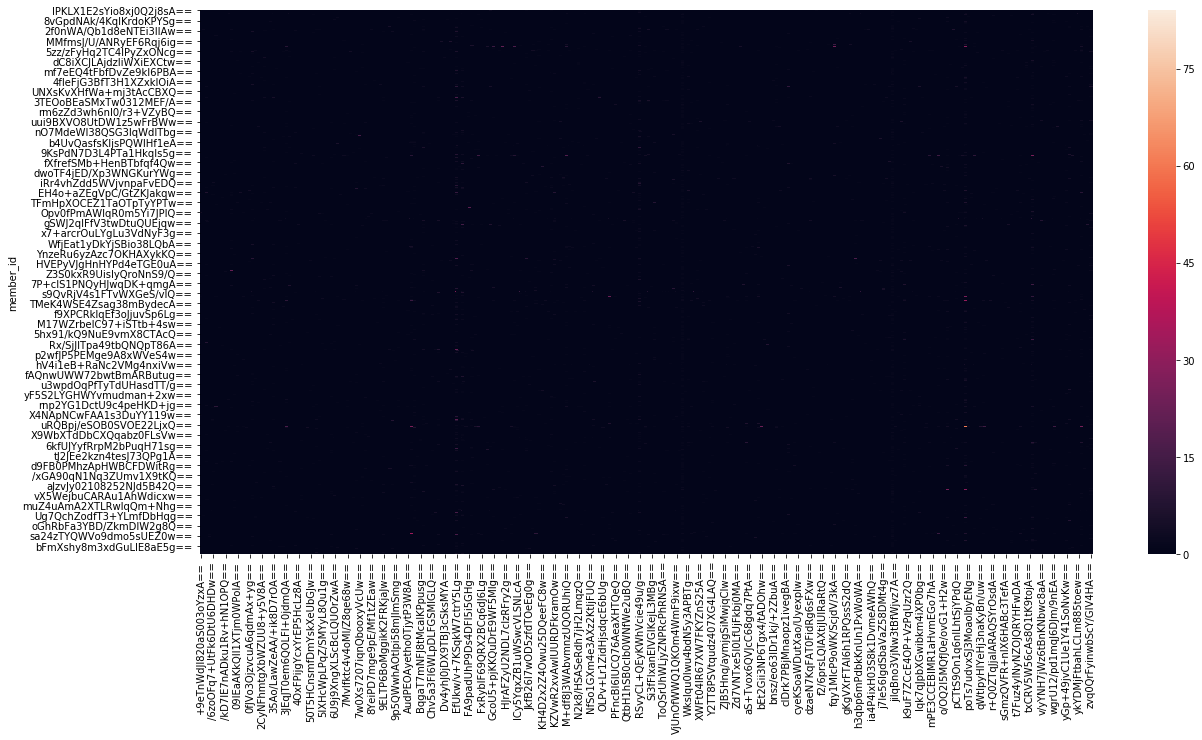

In [6]:
colsums = pivoted.values.sum(axis=0)
pivoted_freq_items = pivoted.loc[:,colsums > 10]

plt.figure(figsize=(20,10))
sns.heatmap(pivoted_freq_items)

### Branches analysis

In [7]:
dist_df.groupBy('branch_id').agg(f.count('*')).show()

+--------------------+--------+
|           branch_id|count(1)|
+--------------------+--------+
|I9eldtFsoYZjW7vcD...|      44|
|CY9rzUYh03PK3k6DJ...|      12|
|YTl5t0XTbCFx9yKzI...|   12142|
|K8Fim3hJi3WbOqAqY...|      25|
|sXGE2+BfdTPaov7x8...|      72|
|eg2Dbdbz8YhXpQTlS...|      97|
|+efNFKUb4Vq3ArVCh...|     270|
|8CBOHT7j5LBd5OLdv...|       6|
|6eIHRpNURGAEMHhUV...|    1156|
|orbQkLpM7JyCDmgoY...|   10382|
|G5skVaSnxIIT2t/yB...|      13|
|NFCPXZOmTt03xJvuJ...|      74|
+--------------------+--------+



In [8]:
dist_branch_pivoted = dist_df.groupBy('branch_id').pivot('item_code').agg(f.sum('quantity')).na.fill(0)
branch_pivoted = dist_branch_pivoted.toPandas().set_index('branch_id')
branch_pivoted.head()

,+6nYgWTz4tkQnudwIjISoA==,+9eTnWdJl820aS003oYzxA==,+AvwVScVeowqe7Y7IvSaqg==,+JkTnfXhBZOWQxQV53DG3Q==,+Q8qylxkAonQopQXvLY6Nw==,+Xa1e7ndJ6oufn3ygliTpg==,+h6cllMUzNeBD7Xqg4MD5Q==,+jo8QH+CN39VwZxdQDM1xw==,+qy81b8dAYkSwRa/J4PpoQ==,+s+fdDsIMAiolO7nuqFkaQ==,...,zL2MqWK4BEXfH384xXdZ8A==,zQy8xmj+S8WOCvPMfgplPQ==,zWOj7sMxn9nITJQqCDFuAA==,zachd+ujYP8Wt/g24nVDcA==,zmySMD840pfiY8cYDwPUAg==,znWECPbvmNfHp7eG7KezqA==,znjR2iVMCEPrI5Ua4Hf/Xw==,zt67bocvU5vvjD+RmHTp1w==,zujWt85SVU/XA1Tje79Eog==,zvq0QrFyinwbScY/GlV4HA==
branch_id,,,,,,,,,,,,,,,,,,,,,
I9eldtFsoYZjW7vcDATo7Q==,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0
CY9rzUYh03PK3k6DJie09g==,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
YTl5t0XTbCFx9yKzIgDKiw==,0.0,0.0,0.0,0.0,0.0,0.0,20.0,2.0,167.0,19.0,...,0.0,0.0,12.0,3.0,0.0,0.0,52.0,0.0,0.0,348.0
K8Fim3hJi3WbOqAqYLwrYg==,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sXGE2+BfdTPaov7x8uLZqQ==,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0


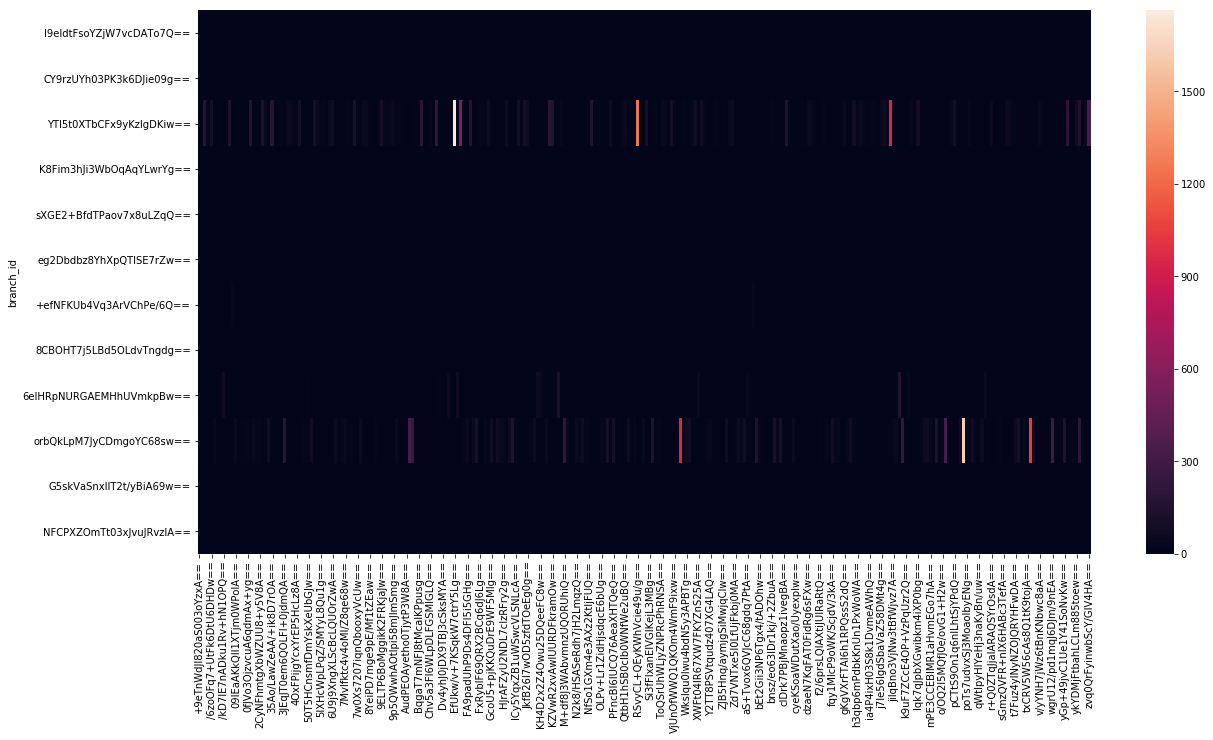

In [9]:
colsums = branch_pivoted.values.sum(axis=0)
branch_pivoted_freq_items = branch_pivoted.loc[:,colsums > 10]

plt.figure(figsize=(20,10))
sns.heatmap(branch_pivoted_freq_items)

### Quantities analysis

In [10]:
dist_df.agg(f.min('quantity'), f.max('quantity')).show()

+-------------+-------------+
|min(quantity)|max(quantity)|
+-------------+-------------+
|           -1|            9|
+-------------+-------------+



In [11]:
dist_df = dist_df.where(f.col('quantity') > 0)
df = dist_df.toPandas()
dist_df.agg(f.min('quantity'), f.max('quantity')).show()

+-------------+-------------+
|min(quantity)|max(quantity)|
+-------------+-------------+
|            1|            9|
+-------------+-------------+



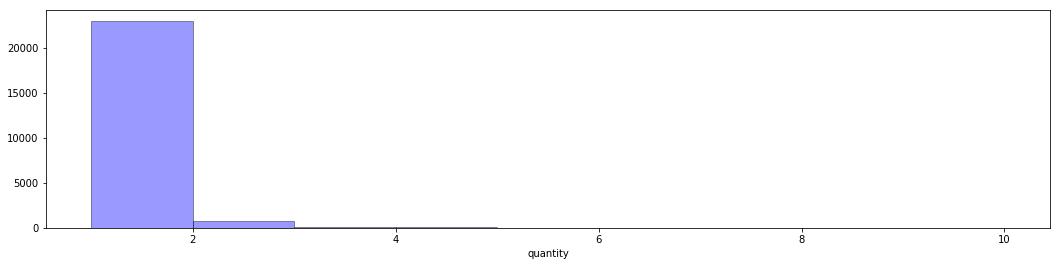

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(18,4))
_ = sns.distplot(df['quantity'].astype(int), hist=True, kde=False, 
             bins=9, color = 'blue',
             hist_kws={'edgecolor':'black'}, ax=ax)

## Basket Analysis

In [13]:
ldf = dist_df.groupBy('member_id').agg(f.collect_set('item_code').alias('items'))
display(ldf.count())
ldf.toPandas().head(10)

2368

,member_id,items
0,0FA2aDI8HfSy46ebrgB7Gw==,"[Zd7VNTxe5I0LfUjFkbj0MA==, ghYSQoJ7cD5qz5xyaUKh5A==, XvBZk4unmaqoReHC6KdivQ==, ltovWQzXJGu94AUQR7DW9w==, jxTkX87qFnpaNt7dS+olQw==, WKL8btOf0IP1XUGCv4iCbQ==, x02XsB6uJX5Eqp1brel7rw==]"
1,2qkpKiHwld05XQE6CVGK7Q==,"[F+2KvtwlWQi+dG0kXlAmOg==, Dgh+xV3L57LXmS1rabUZ+w==, FM/bWbW9ofwkWq2uFbGYSg==, BtWuEF6hvqTYALyWSRh26Q==]"
2,6PxLTVhv9oAXAYTkTO+OYQ==,"[lrm/8BOs7fsdFAV54vvrYw==, jHu7upXBAll15UjO6G363A==, w2G8eywDOoPWY7jZ+0vlbg==]"
3,GBx8WjJH9L7xjCVglwoksA==,"[RSvyCL+QEyKWhVcie49u/g==, jHu7upXBAll15UjO6G363A==]"
4,IPKLX1E2sYio8xj0Q2j8sA==,"[48oESfoup3AaesU/txnFGg==, s/YRMbbs7rKxSDX6ZIpI/w==, h41Wkcgk7iqvdw99NsFR1g==]"
5,K6zzgRlsokXVRAEEdye7cQ==,"[RSvyCL+QEyKWhVcie49u/g==, jHu7upXBAll15UjO6G363A==, lEYmrfnjt2o5GbUNwLCApA==, EfUkw/v+7KSqkW7ctrY5Lg==, zvq0QrFyinwbScY/GlV4HA==]"
6,WZDUwRtk7P3EM0+06vZRwA==,"[z80ghJXVZe9m59/5+Ydk2g==, /qnBHErZo5WmNu2USii1Gg==]"
7,XEs010yvWo0KDHmOh/2iIw==,"[YbH7P1nijGfzkl88eb6BoQ==, KZVwR2xvAwlUURDFkramOw==, 9ELTP6BoMggikK2FRKjaJw==, jHu7upXBAll15UjO6G363A==, JkfB26I7wOD5zfdTOeEg0g==, +qy81b8dAYkSwRa/J4PpoQ==, EfUkw/v+7KSqkW7ctrY5Lg==, zWOj7sMxn9nITJQqCDFuAA==]"
8,e/UK1YWT8VluV+XiSIiTVA==,"[F+2KvtwlWQi+dG0kXlAmOg==, jHu7upXBAll15UjO6G363A==, 3KVnL/NETH6ZeqmixOsglA==, hpj/khFSE6sYfTHU7l2o6g==, ykYDMjFtbahLCLm885toew==, 35Ao/LawZeAA/+ik8D7rOA==]"
9,e6yXGFLcoMZ2R1IIGW0tmA==,"[tzzjmMOfUGr3YdInfYU6kg==, wgrU12/pd1mqJ6DJm/9nEA==, WKL8btOf0IP1XUGCv4iCbQ==]"


In [14]:
fpGrowth = FPGrowth(itemsCol="items", minSupport=0.01, minConfidence=0.8)
model = fpGrowth.fit(ldf)

In [15]:
support = model.freqItemsets
display(support.count())
support.toPandas().head(10)

463

,items,freq
0,[jHu7upXBAll15UjO6G363A==],915
1,[WKL8btOf0IP1XUGCv4iCbQ==],909
2,[RSvyCL+QEyKWhVcie49u/g==],498
3,"[RSvyCL+QEyKWhVcie49u/g==, jHu7upXBAll15UjO6G363A==]",361
4,[EfUkw/v+7KSqkW7ctrY5Lg==],491
5,"[EfUkw/v+7KSqkW7ctrY5Lg==, RSvyCL+QEyKWhVcie49u/g==]",180
6,"[EfUkw/v+7KSqkW7ctrY5Lg==, RSvyCL+QEyKWhVcie49u/g==, jHu7upXBAll15UjO6G363A==]",128
7,"[EfUkw/v+7KSqkW7ctrY5Lg==, jHu7upXBAll15UjO6G363A==]",353
8,[peABMjc6cDEAD9mHo8n4ew==],447
9,"[peABMjc6cDEAD9mHo8n4ew==, WKL8btOf0IP1XUGCv4iCbQ==]",439


In [16]:
rules = model.associationRules
display(rules.count())
rules.toPandas().head(10)

144

,antecedent,consequent,confidence,lift
0,[09lEaAKkQll1XTjm0WPoIA==],[WKL8btOf0IP1XUGCv4iCbQ==],1.000000,2.605061
1,"[BYTOVlyCS3t/UCgtmhmUWw==, tzzjmMOfUGr3YdInfYU6kg==]",[WKL8btOf0IP1XUGCv4iCbQ==],1.000000,2.605061
2,[JyPQkrY4heDXwmDMAH6LnQ==],[WKL8btOf0IP1XUGCv4iCbQ==],0.971429,2.530630
3,"[3JEqJT0em6QOLFl+0jdmQA==, BYTOVlyCS3t/UCgtmhmUWw==, peABMjc6cDEAD9mHo8n4ew==]",[WKL8btOf0IP1XUGCv4iCbQ==],1.000000,2.605061
4,[ToQSrUhWLjyZNPRcPhRNSA==],[jHu7upXBAll15UjO6G363A==],0.842105,2.179350
5,"[jxTkX87qFnpaNt7dS+olQw==, tzzjmMOfUGr3YdInfYU6kg==, peABMjc6cDEAD9mHo8n4ew==]",[WKL8btOf0IP1XUGCv4iCbQ==],0.981481,2.556819
6,[3JEqJT0em6QOLFl+0jdmQA==],[WKL8btOf0IP1XUGCv4iCbQ==],0.990291,2.579769
7,"[X5P5g1JN7z3KRkRp0s+fPg==, tzzjmMOfUGr3YdInfYU6kg==]",[WKL8btOf0IP1XUGCv4iCbQ==],1.000000,2.605061
8,"[oBoDgMo8YUKMJqIx8OSaCQ==, tzzjmMOfUGr3YdInfYU6kg==]",[peABMjc6cDEAD9mHo8n4ew==],0.854167,4.524981
9,"[oBoDgMo8YUKMJqIx8OSaCQ==, tzzjmMOfUGr3YdInfYU6kg==]",[WKL8btOf0IP1XUGCv4iCbQ==],0.979167,2.550788


In [17]:
fp_predictions = model.transform(ldf)
fp_recommendations = fp_predictions\
.where(f.size('prediction') > 0)\
.select(f.col('member_id'), f.col('items').alias('fp_recommendations'))

display(fp_recommendations.count())
fp_recommendations.toPandas().head(10)

95

,member_id,fp_recommendations
0,yHQG7BdHYy4wqHKssJlN5A==,"[5lXHcWpLPqZ/SMYyL8Qu1g==, 8Lusb6B58eALLBTB08bM8A==, KZVwR2xvAwlUURDFkramOw==, RSvyCL+QEyKWhVcie49u/g==, 2qltloGiFEV3JFTL3fDKwQ==, Xna+9uAZslQf9T2zn0B6mA==, coNRjUegWgnTN3mhet8XBw==, +qy81b8dAYkSwRa/J4PpoQ==, /qnBHErZo5WmNu2USii1Gg==, EfUkw/v+7KSqkW7ctrY5Lg==, JhKqiS2WLW+AVrGVym5VDQ==, yTDuzQGTX+71WULMRF9wjw==, q1Qdh0x7wZq3dkKEngK4nw==]"
1,B8Bivbclcnj5YdpPzjVO8A==,"[lqk7qJpbXGwibkm4iXP0bg==, EfUkw/v+7KSqkW7ctrY5Lg==]"
2,wFMtsCXg2TFGl1g2qDzUkA==,"[oBoDgMo8YUKMJqIx8OSaCQ==, tzzjmMOfUGr3YdInfYU6kg==, FnkJHFqID69vteYIfrGy3A==, WKL8btOf0IP1XUGCv4iCbQ==]"
3,In0ulaDQ78N/giFmTL3DoQ==,"[lqk7qJpbXGwibkm4iXP0bg==, peABMjc6cDEAD9mHo8n4ew==, F+2KvtwlWQi+dG0kXlAmOg==, H/Hed0AF+NoT9ClDiBxlXw==, RSvyCL+QEyKWhVcie49u/g==, M+df8J3WAbvmnzUQORUhiQ==, BtWuEF6hvqTYALyWSRh26Q==, gchyfGLoAL5wjb83xGld/w==, EfUkw/v+7KSqkW7ctrY5Lg==, zvq0QrFyinwbScY/GlV4HA==, yTDuzQGTX+71WULMRF9wjw==, WKL8btOf0IP1XUGCv4iCbQ==]"
4,reG5aWqjydRjh5onb544kg==,"[HNOII5RSCHbciNFHKqKpPw==, 8K3Ig49L3t3k7Cz60FFViQ==, clDrk7PBjMnaopz1ivegBA==, gedNZ4WBo7t6cgsBn08akw==, G6/3DiZp6DdjR+/TqHSjQQ==, BtWuEF6hvqTYALyWSRh26Q==, coNRjUegWgnTN3mhet8XBw==, ykYDMjFtbahLCLm885toew==, GNENxuZm6rbekhWuWz1U3w==, +s+fdDsIMAiolO7nuqFkaQ==, DIzlUWMFXE2lCoHgonNGjA==, joKrckO3xm12jxuM4cln6w==, 8bbyhX+21E3XPHBB4KoPGQ==, 8YeiPD7mge9pE/Mf1tZEaw==, FM/bWbW9ofwkWq2uFbGYSg==, lrm/8BOs7fsdFAV54vvrYw==, AfeL5vfK0CZYUI/kYWCYqQ==, jr2lQMvMTXM2SWgZpGobaA==, 9cPddRS/YgobhUUNKuN0sQ==, z80ghJXVZe9m59/5+Ydk2g==, z6UwE1i5/L56pFsc7qCIxg==, IQ92ConbMKpyyiWKNIPMfw==, EfUkw/v+7KSqkW7ctrY5Lg==, 6P1KilurKzeF15SrUf71XA==, KZ+yFC196Vk4D5HAHDopPA==, 2G6mEt7JYJbF4PzI3UKrbQ==, Ib6aS9T4FUmp0dJBmBzsPA==]"
5,dohX0pUp/0Ffd7VD7BPE4g==,"[FM/bWbW9ofwkWq2uFbGYSg==, RSvyCL+QEyKWhVcie49u/g==, IQ92ConbMKpyyiWKNIPMfw==, XUTubyw/cbcxJYdhA8j2xA==, Ib6aS9T4FUmp0dJBmBzsPA==]"
6,J6obOYdil/stOPLA7m9aUA==,"[crMqH3VLocCbNpXgy2zefw==, tzzjmMOfUGr3YdInfYU6kg==]"
7,Zgf8S3QyqHjL2Co7gkS7eA==,"[FM/bWbW9ofwkWq2uFbGYSg==, RSvyCL+QEyKWhVcie49u/g==]"
8,RkqHG5MUrGU7etImhjRyGA==,"[Dyi11JswIK/uzZW0AJrfTA==, t7Fuz4ylNyNZOJQRYHFwDA==, gWsRLGEFs+vVN4KKOa9IGA==, BYTOVlyCS3t/UCgtmhmUWw==, tTs6PWq5DOAmgikVHJveEQ==, FnkJHFqID69vteYIfrGy3A==, wgrU12/pd1mqJ6DJm/9nEA==, b0ki9FVoFhqM30rSKZ9tIw==, A6/b1m55KbEl+Fl4NPqDpA==, 2CyNFhmtgXbWZUU8+y5V8A==, oBoDgMo8YUKMJqIx8OSaCQ==, tzzjmMOfUGr3YdInfYU6kg==, z80ghJXVZe9m59/5+Ydk2g==, bqmrG6oO+54ZCURAwxfiGw==, 0fSRpATWhUiAlD5cPNnKJQ==, BkCWYyJq8vMRRIWqTgojtA==, WKL8btOf0IP1XUGCv4iCbQ==]"
9,7upZoS2JO+aNXqWQRNsgtg==,"[peABMjc6cDEAD9mHo8n4ew==, ZRK9Q9nKpuAsmQsKgmUtyg==, 8JNeTNWSCqbHyZal7lOnDw==]"


## Collaborative Filtering

In [18]:
ratings = dist_df.groupBy('member_id', 'item_code').agg(f.sum('quantity').alias('quantity'))
display(ratings.count())
ratings.show()

13314

+--------------------+--------------------+--------+
|           member_id|           item_code|quantity|
+--------------------+--------------------+--------+
|ApJ94e5x84NtxljSY...|wWpTIPpHVTDZWDw0/...|     1.0|
|S0xGvejVjWCSoL+NV...|NBc8s48H+J3b68Ksk...|     1.0|
|sIfW8ZeFQMnxnOLnC...|tzzjmMOfUGr3YdInf...|     8.0|
|qsxVEiLEuDqpC4Xfn...|WKL8btOf0IP1XUGCv...|     1.0|
|14P5vT59YiFsWPyxg...|ZoCOMn3HnRNboY4FF...|     1.0|
|xr7Aqi7Y9mniUA5Ta...|/p/CicP/CvFCttO+r...|     3.0|
|CXg4P3jqibPnec7Ae...|ttdn0vjtXSGkSw5Yh...|     5.0|
|Bz2KwsqmI/7AXH9vf...|7w0Xs7207iqnQboox...|     1.0|
|GEET1Z5KeM8r36mZ+...|BkCWYyJq8vMRRIWqT...|     2.0|
|XPbiftcfCpvLwFBk/...|NfSo1GXm4e3AXz2Kt...|     2.0|
|RkqHG5MUrGU7etImh...|BkCWYyJq8vMRRIWqT...|     1.0|
|WNYZX12d0dNuI3Ww6...|fvYF/I26VCXWll+9T...|     1.0|
|AmTox7h/mKDwktgQ7...|B+HNfcqJoWeAQkdxg...|     1.0|
|My/MXfCvSG713naQ6...|jxTkX87qFnpaNt7dS...|     7.0|
|3N4MAva8qUOwPJjMI...|RSvyCL+QEyKWhVcie...|     1.0|
|pU5hvSZGMFH0BwlP4...|Nl0XdwCAyAeg5HrpE...|   

In [19]:
indexers = [StringIndexer(inputCol=c, outputCol="{}_index".format(c)).fit(ratings) for c in ['member_id', 'item_code']]
pipeline = Pipeline(stages=indexers)
indexed = pipeline.fit(ratings).transform(ratings)
indexed.show()

+--------------------+--------------------+--------+---------------+---------------+
|           member_id|           item_code|quantity|member_id_index|item_code_index|
+--------------------+--------------------+--------+---------------+---------------+
|ApJ94e5x84NtxljSY...|wWpTIPpHVTDZWDw0/...|     1.0|          561.0|          208.0|
|S0xGvejVjWCSoL+NV...|NBc8s48H+J3b68Ksk...|     1.0|         1739.0|           45.0|
|sIfW8ZeFQMnxnOLnC...|tzzjmMOfUGr3YdInf...|     8.0|         1847.0|            5.0|
|qsxVEiLEuDqpC4Xfn...|WKL8btOf0IP1XUGCv...|     1.0|          242.0|            1.0|
|14P5vT59YiFsWPyxg...|ZoCOMn3HnRNboY4FF...|     1.0|          825.0|          290.0|
|xr7Aqi7Y9mniUA5Ta...|/p/CicP/CvFCttO+r...|     3.0|           14.0|          266.0|
|CXg4P3jqibPnec7Ae...|ttdn0vjtXSGkSw5Yh...|     5.0|           99.0|           92.0|
|Bz2KwsqmI/7AXH9vf...|7w0Xs7207iqnQboox...|     1.0|         1291.0|          263.0|
|GEET1Z5KeM8r36mZ+...|BkCWYyJq8vMRRIWqT...|     2.0|          689

In [20]:
member_mapping = indexed.select("member_id", "member_id_index").distinct()
print member_mapping.count()
member_mapping.show()

2368
+--------------------+---------------+
|           member_id|member_id_index|
+--------------------+---------------+
|pU5hvSZGMFH0BwlP4...|          934.0|
|9oIwN+2O/nCU+EBG7...|           55.0|
|bzr4gTOAcpdviQBDM...|          151.0|
|x4EyVt+g/QQ10y5C2...|          143.0|
|n0SCPM0EOQxiOF3be...|          726.0|
|oHfbLXuC/RI5us1tT...|          452.0|
|rXsy/fmfBBWG0YP4h...|         1924.0|
|fnNtC7w1itA4iFt3P...|          400.0|
|XEX7HzCsgrVkI4Qam...|         2142.0|
|g75QlsiMCv71rVaZ4...|          720.0|
|QhizACIzczdC/CdNJ...|         1792.0|
|WGBX0mWiU6ieT/9YB...|         2351.0|
|2pKGgLs/x+wEBP6SA...|         2230.0|
|zb3XjNtXC0291slwA...|          191.0|
|hyAxYnb1vXxj+Uvxf...|         2200.0|
|2ncmnBbwN8stuui46...|         1445.0|
|57R47tNa81qaMLd17...|         1294.0|
|L872/09KKS/HudEm/...|         1213.0|
|JUmPnpderz/qsnzvQ...|          653.0|
|6kfUJYyfRrpM2bPuq...|         1020.0|
+--------------------+---------------+
only showing top 20 rows



In [21]:
item_mapping = indexed.select("item_code", "item_code_index").distinct()
print item_mapping.count()
item_mapping.show()

900
+--------------------+---------------+
|           item_code|item_code_index|
+--------------------+---------------+
|vUyatzD1UTIGuZnsD...|          231.0|
|CP4mIdjnFrAuwNo1J...|          552.0|
|VafPnHHxycSVQT+TT...|          485.0|
|l0FqwPWAVpR+LrXV0...|          564.0|
|uhs+ujIuq12JWqMCP...|          253.0|
|WdEYDfg4dg5ZJ9MjT...|          788.0|
|DIzlUWMFXE2lCoHgo...|          322.0|
|Si3fFIxanEIVGlKej...|          306.0|
|Hk02F31xu7NVjkOvl...|          759.0|
|Qud7Y2N6s4Hovl+DG...|          855.0|
|M7uDcgup0rbahxFDg...|          866.0|
|qMiKAFX2NuShY6Xj0...|          896.0|
|eJX8EwiO439RGRO6x...|          229.0|
|Ao7nJBV7BdBOe9zyN...|          810.0|
|F7PHBheI2+gt5avp9...|          796.0|
|CcbDeDtKcAVNp08lO...|          649.0|
|OLPv+Lr1ZidHjsdqc...|          126.0|
|twaDXeeaK06AUG9YK...|          438.0|
|rEFspI9NeIrCV/Ygy...|          636.0|
|voOrPs0Nt3PrLcGwo...|          575.0|
+--------------------+---------------+
only showing top 20 rows



In [22]:
train, test = indexed.randomSplit([0.8, 0.2])
display('train count: {0}, test count: {1}'.format(train.count(), test.count()))

'train count: 10737, test count: 2577'

In [23]:
als = ALS(maxIter=5,
          regParam=0.01,
          implicitPrefs=True,
          userCol="member_id_index",
          itemCol="item_code_index",
          ratingCol="quantity",
          coldStartStrategy="drop")

model = als.fit(train)

In [24]:
cf_predictions = model.transform(test)
evaluator = RegressionEvaluator(metricName="rmse",
                                labelCol="quantity",
                                predictionCol="prediction")
rmse = evaluator.evaluate(cf_predictions)
display("Root-mean-square error = " + str(rmse))

'Root-mean-square error = 3.84919447665'

In [25]:
print cf_predictions.count()
cf_predictions.show()

2462
+--------------------+--------------------+--------+---------------+---------------+-------------+
|           member_id|           item_code|quantity|member_id_index|item_code_index|   prediction|
+--------------------+--------------------+--------+---------------+---------------+-------------+
|oKUSSooO8VyY+OaEr...|Xp+SoByYa6/Ku6/RR...|     1.0|          274.0|          148.0| -0.043895587|
|JRQG4dJslAXhtFk8y...|Xp+SoByYa6/Ku6/RR...|     1.0|          636.0|          148.0|  0.015721774|
|aeLsiZ0eu8hybKJDj...|Xp+SoByYa6/Ku6/RR...|     1.0|         1934.0|          148.0| 0.0016821616|
|Br6KK3ewPmOJMtk1O...|Xp+SoByYa6/Ku6/RR...|     1.0|         1724.0|          148.0|-0.0012173438|
|3UoNz60CqDn9CIcZr...|Xp+SoByYa6/Ku6/RR...|     1.0|          357.0|          148.0|    0.0766778|
|fNDWKooUi13LM67+J...|Xp+SoByYa6/Ku6/RR...|     2.0|           66.0|          148.0|   0.09517239|
|IWBIDYMbE7/16CesN...|Jp2DevraMI3Urqsoy...|     1.0|          297.0|          463.0|  4.410874E-4|
|D3t2

Generate top 10 items recommendations for each user

In [26]:
cf_member_recommendations = model.recommendForAllUsers(5)
print cf_member_recommendations.count()
cf_member_recommendations.show()

2337
+---------------+--------------------+
|member_id_index|     recommendations|
+---------------+--------------------+
|           1580|[[5, 0.39873713],...|
|            471|[[3, 0.42523593],...|
|           1591|[[1, 0.77127963],...|
|           1342|[[58, 0.68964756]...|
|           2122|[[0, 0.9605875], ...|
|           2142|[[0, 0.95103514],...|
|            463|[[7, 0.09584703],...|
|            833|[[0, 0.9562496], ...|
|           1645|[[5, 0.86738825],...|
|            496|[[3, 1.1716663], ...|
|           2366|[[7, 0.0011710152...|
|            148|[[2, 0.7946232], ...|
|           1088|[[1, 1.0257378], ...|
|           1238|[[0, 0.031136606]...|
|           1829|[[1, 0.87660867],...|
|           1959|[[0, 0.92394686],...|
|            540|[[0, 1.0512234], ...|
|           1460|[[1, 0.93130463],...|
|           1990|[[1, 0.8885434], ...|
|           1721|[[1, 0.6915444], ...|
+---------------+--------------------+
only showing top 20 rows



In [27]:
cf_member_recommendations = cf_member_recommendations\
.select('member_id_index', f.explode('recommendations'))\
.select('member_id_index', f.col('col.item_code_index'))\
.join(member_mapping, ['member_id_index']).join(item_mapping, ['item_code_index'])\
.groupBy('member_id').agg(f.collect_set('item_code').alias('cf_recommendations'))

cf_member_recommendations.toPandas().head(10)

,member_id,cf_recommendations
0,qvFtfG5sIVq4YZKd7JZqMQ==,"[RSvyCL+QEyKWhVcie49u/g==, M+df8J3WAbvmnzUQORUhiQ==, jHu7upXBAll15UjO6G363A==, fqy1MlcP9oWK/ScjdV/3kA==, zvq0QrFyinwbScY/GlV4HA==]"
1,hl1aNDmSBcbQFRrmlQgmcQ==,"[tzzjmMOfUGr3YdInfYU6kg==, peABMjc6cDEAD9mHo8n4ew==, M+df8J3WAbvmnzUQORUhiQ==, jxTkX87qFnpaNt7dS+olQw==, WKL8btOf0IP1XUGCv4iCbQ==]"
2,j5H9d3h3ywTDiG5XIOke3A==,"[oBoDgMo8YUKMJqIx8OSaCQ==, RSvyCL+QEyKWhVcie49u/g==, M+df8J3WAbvmnzUQORUhiQ==, jHu7upXBAll15UjO6G363A==, fqy1MlcP9oWK/ScjdV/3kA==]"
3,e6yXGFLcoMZ2R1IIGW0tmA==,"[tzzjmMOfUGr3YdInfYU6kg==, peABMjc6cDEAD9mHo8n4ew==, jxTkX87qFnpaNt7dS+olQw==, 35Ao/LawZeAA/+ik8D7rOA==, WKL8btOf0IP1XUGCv4iCbQ==]"
4,yHQG7BdHYy4wqHKssJlN5A==,"[RSvyCL+QEyKWhVcie49u/g==, +qy81b8dAYkSwRa/J4PpoQ==, EfUkw/v+7KSqkW7ctrY5Lg==, yTDuzQGTX+71WULMRF9wjw==, WKL8btOf0IP1XUGCv4iCbQ==]"
5,yUSSot1XYtCFshk42v0CLA==,"[lqk7qJpbXGwibkm4iXP0bg==, RSvyCL+QEyKWhVcie49u/g==, jHu7upXBAll15UjO6G363A==, XUTubyw/cbcxJYdhA8j2xA==, KZ+yFC196Vk4D5HAHDopPA==]"
6,hmblJu9fezicxylkbsoCMw==,"[F+2KvtwlWQi+dG0kXlAmOg==, jHu7upXBAll15UjO6G363A==, BtWuEF6hvqTYALyWSRh26Q==, EfUkw/v+7KSqkW7ctrY5Lg==, zvq0QrFyinwbScY/GlV4HA==]"
7,2qkpKiHwld05XQE6CVGK7Q==,"[F+2KvtwlWQi+dG0kXlAmOg==, Dgh+xV3L57LXmS1rabUZ+w==, FM/bWbW9ofwkWq2uFbGYSg==, BtWuEF6hvqTYALyWSRh26Q==, zvq0QrFyinwbScY/GlV4HA==]"
8,GBx8WjJH9L7xjCVglwoksA==,"[lqk7qJpbXGwibkm4iXP0bg==, RSvyCL+QEyKWhVcie49u/g==, jHu7upXBAll15UjO6G363A==, XUTubyw/cbcxJYdhA8j2xA==, KZ+yFC196Vk4D5HAHDopPA==]"
9,v0vltc8wY8qo3wL1OmIjQA==,"[F+2KvtwlWQi+dG0kXlAmOg==, RSvyCL+QEyKWhVcie49u/g==, 0s3wR6ZnTO8lHVZUSjzwKQ==, z80ghJXVZe9m59/5+Ydk2g==, KZ+yFC196Vk4D5HAHDopPA==]"


Generate top 10 user recommendations for each movie

In [28]:
item_recommendations = model.recommendForAllItems(100)
display(item_recommendations.count())
item_recommendations.show()

840

+---------------+--------------------+
|item_code_index|     recommendations|
+---------------+--------------------+
|            471|[[1, 0.030739019]...|
|            463|[[14, 0.007834743...|
|            833|[[60, 0.007903773...|
|            496|[[60, 0.028148927...|
|            148|[[12, 0.17469846]...|
|            540|[[23, 0.00911929]...|
|            392|[[36, 0.02381343]...|
|            243|[[0, 0.0533574], ...|
|            737|[[60, 0.004109793...|
|            897|[[165, 0.04205972...|
|            858|[[494, 9.999176E-...|
|             31|[[100, 0.7027786]...|
|            516|[[538, 3.4467107E...|
|            580|[[494, 4.4029985E...|
|            251|[[12, 0.03927491]...|
|            451|[[101, 0.12236079...|
|             85|[[292, 0.17389128...|
|            137|[[100, 0.10481515...|
|            808|[[27, 0.023946982...|
|            883|[[30, 1.6074366E-...|
+---------------+--------------------+
only showing top 20 rows



In [29]:
item_recommendations = item_recommendations\
.select('item_code_index', f.explode('recommendations'))\
.select('item_code_index', f.col('col.member_id_index'))\
.join(item_mapping, ['item_code_index']).join(member_mapping, ['member_id_index'])\
.groupBy('item_code').agg(f.collect_set('member_id').alias('recommendations'))

item_recommendations.toPandas().head(10)

,item_code,recommendations
0,5g6BxMvlFxzWVGYtmIeuwg==,"[DsWRhRsnH7YukAAMYI4YUw==, sLhnLqNEzpMQcHjPu892tQ==, oKUSSooO8VyY+OaErr4jpA==, hafxw17tQlmxpb1QeH0DVg==, Z9Hu/Ck055Abk/sVKvDwgg==, 9GSzaaLxehSXHkvrU7vV0w==, B8yXwi4Up/sHmLVeDfF94Q==, 6fYa/8a+7Qig0CZDQZ4Img==, M6H1incoruGIYOIjyX5ayg==, XWOuyB9hhzDqwU5hTvtOCw==, UXRuWIOm1Y1PXsPALF3C0w==, MurhRw1k+OJzhZfK9TS3bg==, 1zqWhVHUZkt/0dIaQ/ORGA==, l8k4Ut4TpwHly4bCqH69uA==, SArOvmt8Svc+oxgbAGAGJw==, U2BC6P9Yh+xCDFBkEz1q5g==, 5TPxnaOoGNwnp4Zvj83xlA==, Mi2oZqh/iq7hxBIFaFqAlw==, Oi4CZk5aEJTwJKcUX12l7w==, 2MPUmLXUHk9BUKDvYGBheQ==, /egLFyLYeKlV4kvV7H4qGQ==, 6K1sy9iYEvhVxTgXsmrsnw==, DLOocTlUF4HIRm6OGDoAEA==, xTCatPXqwjfSaIGSXYULLg==, 9pyyBPIt/NURe9doV5DuYg==, aVADQSFMUI7xX2p1kT/reQ==, Q2e82EzI5thUxuVquHeFlw==, rawq73pUtnQATtgO/76pjg==, MB5icQ4xBfbDzsG3xiQfTQ==, Y/TXh60k/OKIR8Jot3633g==, rFJ5cS69bYPLi1Lg5Vd5OA==, 029iE6POYlM16CL1T9Ov+Q==, BwrfGwjJ8tvBqQdlbSfXGQ==, o6FGp4IqOh1K4MtqdzPGSg==, fN8dXM72gWoXqlg7LmRRCQ==, Pzyu9JOKK4C2jpO/LP74zw==, mf7eEQ4tFbfDvZe9kI6PBA==, spxUESN06YVySPRhWiABPg==, Dc4VDfyIMM5runU6UKEHYg==, Cx9aRjbPyKgVypHImnauRg==, TngDnNbtLovhGzSBkafDQA==, XFEhijvPNurRgZzsmGDRCg==, LiJLl6PeAqDLngXjfhU+Bg==, lPDeJhOhNq8bG09zEYYRzw==, dXHX8KB9nACEt1wCrYnPsA==, ejDEVBDO5kixjg0UZ2vuZw==, LeVuk9q2fhl9DHCEmisW3w==, 0XXRrQzfSNCm8G8yhhG7sA==, 1Cfb//0uVK05MLzWefve2A==, tdWGMowcUBAEbJkoUfyQFQ==, rnp2YG1DctU9c4peHKD+jg==, DWyVLIlOR/RL2sZHsIuw0g==, ppOMkmXG3TNYRIR5Lr/L6w==, Ok4SDHkNU3bx7Xz7qjGCGw==, eEqfv6xloh9u7Iiqw3/1lg==, ekmZeec66dQ/64ttMVu2OA==, 5TNU5Q/Vj3fPVAzMBgwDFA==, hnc0vJX60XgnIQJbym693A==, HkZCm01NHTP2kSJ4b+jAdw==, yHQG7BdHYy4wqHKssJlN5A==, D6ypb1c0NO5tPJUTOir+Hg==, L19XGDqFBEoZEf7n3r/0aw==, E1L/4y62NXq3MvM+ciQ1+w==, tWnGJarS1Xud3CLT42qsng==, GE5Dpr9f7/yqs5L+AhuYwA==, mn84mSG0zEs1p9KcLBlCkw==, umMpXMTl/FI+buCk0stezQ==, OSByJDEsjQWYveMa5vhK0g==, I1fRpwF9JyxIkWjGlhqvyQ==, JvdUWUKxusEkkUBw2YNWPA==, bzr4gTOAcpdviQBDMo4GpQ==, 08FxCSQusxBrvYnPPTW4Tg==, xCFMawGGl0LqaFSCJa6qxw==, u/cd4Olg1BsfqYyMquoQAQ==, RNYkbDg4woJSt/YFowtIJw==, Y86vNBZg59UmnUzet6Z/Jg==, DwL8Xg1FQfIDXwxqvykOxQ==, HuGBicFz6coQpbHKnqfQrA==, BRnwkfyO7pIoCnSJ13M4jA==, ERj1ue0mFdb/n8MAr3czjQ==, jS5rsxrgfS7kD6D33HLwnw==, Z9/chbrUzcRA2a6OH3TjyA==, LnQA0VN2VdxBOJsgysiuyg==, 3SvxKHsNKUJUCp5bNHB44Q==, 5LPIE2P4qBhl9XB+hMnjqw==, 677mQGlh3B8RKE6sfCLsXw==, gSWJ2qIFfV3twDtuQUEjqw==, dohX0pUp/0Ffd7VD7BPE4g==, 9x3CIolp3OJ178ZShHGErw==, aiCO2a0UU7/zHDBQJvS1cQ==, GP1JbWCHTsypStZ6WAfXbA==, 6OMhKOuooyIcLTSFP6sxDg==, uCtX05ufpODGx2nGQTEyBQ==, lBkJ3t4yPQ4wFd4hU689mw==, Z9Zcn2yyMnXDFMEbmNv8RQ==, jlCXuJCijsL2+chvZtyB2A==, M6PpFTxG7TT8vQFDCaD1eA==, pxmu+/ReGgdUvTbD2/ULlw==, a13Ku9GJzBvo6UE6XB9uFQ==, Ojq0KPxO4T4dUwBAECIqTg==]"
1,WKL8btOf0IP1XUGCv4iCbQ==,"[HGulT1cfKHowju1WzS8f0w==, gxbZqtPht1Gw9a8hTHLGOw==, My/MXfCvSG713naQ6hRPsw==, Q8t1wXv7iLC72526OP28xA==, e81isg1C4yPlZ5IqRxv7qQ==, FXWzIj+9DvNHIombbJtNDg==, fLzYLnuXMamE11gVH5gdgw==, BdMXTWnlSe6t1DjMkyH58w==, 0CqDsDx7yT0blGh9uK5WNQ==, XPbiftcfCpvLwFBk/ZnFBg==, bRjYjXeta1/Jr4P7CI4VcQ==, 6uBbpkZxLnp8dKKKQf0xlg==, DgoxQE63L9HMmba5ToJdiQ==, m8T+8R/GrCkbzPQ2y4jL9Q==, pj19eNdVRfnvXsG4BnbVGQ==, 10524IuclsZiYDBG5ojpCg==, X3NtDya4zE6hxI3ZfubdeQ==, //NvUKmk9QNxJzEQ+vgaEg==, aHy6xEvG/OWa177vSK5+ng==, S4OTCnsUacrK5q9ShZ+dvw==, g03/3foT5TbnKKLorYflNQ==, W1lZkowuZQjVvyVwus7/Ng==, Gi9XLpq2rmR17JC7ou4uOg==, k197yv+xioK+zaXyzA4CWQ==, 1KNnpXDsdHb8DiMF0KT1Ug==, DoUmRzV0rmDLEsId70j5Rg==, aIgojc0ozBzOHZgH0lDANg==, KxfyKXYJe6U6JjNJsxyY1A==, HBlwqZHEGK0InQHK94HeCg==, bkcaxr0reH4yhfpiMsI03g==, 4TpfV8ExYAz/MkF72xREgg==, IvO4Wbx2Ej5ow7M7EZ7W+A==, n9lvVbJtv9NZvHbfUXAnBA==, uQ1SXmTKjKcw/kH1H7tQxg==, hSrsVjfT3mdJ0Z2ARE7Llw==, 5/J19Iow7u4QSF7pcHvy+w==, bPi37MbcljuuPHj+CpVvtg==, m5yIMAH7PvZhDNkFZp2JiQ==, anRnY8qOGGkRkvZEUbthrA==, AmTox7h/mKDwktgQ779vlw==, 7NRNRlt0Y1JtcEuxpnnxNA==, kmuerru0QDR7cxlzs7DvZQ==, GRlVto9Vvef7CQKmL2Yjiw==, Wkl3epzhcCpBjKS5oxD+zQ==, +mcLyMz6orZ9728XbqdGxQ==, VMKkwSG1LnG93QoALdn+lA==, RQpXvR52Fv02JiKi+Xiz/Q==, 5MYHdvzjQ7WTSwR1Rr1IMg==, /8Rvqq3oKCcr3+X7ohTSgg==, ah4/yMM+AaCxk6mv4fGvSQ==, gd/CgT3pG/gPwX

predict for specific members

In [30]:
# movies = ratings.select(als.getItemCol()).distinct().limit(3)
# movieSubSetRecs = model.recommendForItemSubset(movies, 10)predict for specific members

predict for specific items

In [31]:
# users = ratings.select(als.getUserCol()).distinct().limit(3)
# userSubsetRecs = model.recommendForUserSubset(users, 10)

## Recommendations by frequency

In [32]:
members_counts = dist_df\
.groupBy('item_code')\
.agg(f.count('*').alias('members_count'))\
.orderBy(f.col('members_count').desc())\
.toPandas()

top_5_members_counts = members_counts.head(5)
top_5_members_counts

,item_code,members_count
0,EfUkw/v+7KSqkW7ctrY5Lg==,1707
1,peABMjc6cDEAD9mHo8n4ew==,1455
2,RSvyCL+QEyKWhVcie49u/g==,1183
3,WKL8btOf0IP1XUGCv4iCbQ==,974
4,jHu7upXBAll15UjO6G363A==,970


In [33]:
top_5_mc_str = ','.join(list(top_5_members_counts.item_code))
top_5_mc_str

u'EfUkw/v+7KSqkW7ctrY5Lg==,peABMjc6cDEAD9mHo8n4ew==,RSvyCL+QEyKWhVcie49u/g==,WKL8btOf0IP1XUGCv4iCbQ==,jHu7upXBAll15UjO6G363A=='

In [34]:
quantity_sums = dist_df\
.groupBy('item_code')\
.agg(f.sum('quantity').alias('quantity_sum'))\
.orderBy(f.col('quantity_sum').desc())\
.toPandas()

top_5_quantity_sums = quantity_sums.head(5)
top_5_quantity_sums

,item_code,quantity_sum
0,EfUkw/v+7KSqkW7ctrY5Lg==,1801.0
1,peABMjc6cDEAD9mHo8n4ew==,1638.0
2,RSvyCL+QEyKWhVcie49u/g==,1261.0
3,tzzjmMOfUGr3YdInfYU6kg==,1051.0
4,WKL8btOf0IP1XUGCv4iCbQ==,974.0


In [35]:
top_5_qs_str = ','.join(list(top_5_quantity_sums.item_code))
top_5_qs_str

u'EfUkw/v+7KSqkW7ctrY5Lg==,peABMjc6cDEAD9mHo8n4ew==,RSvyCL+QEyKWhVcie49u/g==,tzzjmMOfUGr3YdInfYU6kg==,WKL8btOf0IP1XUGCv4iCbQ=='

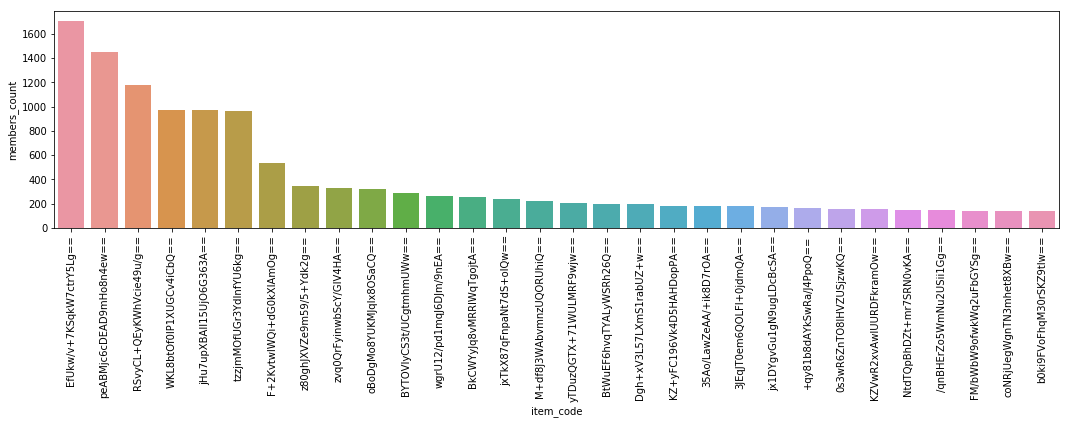

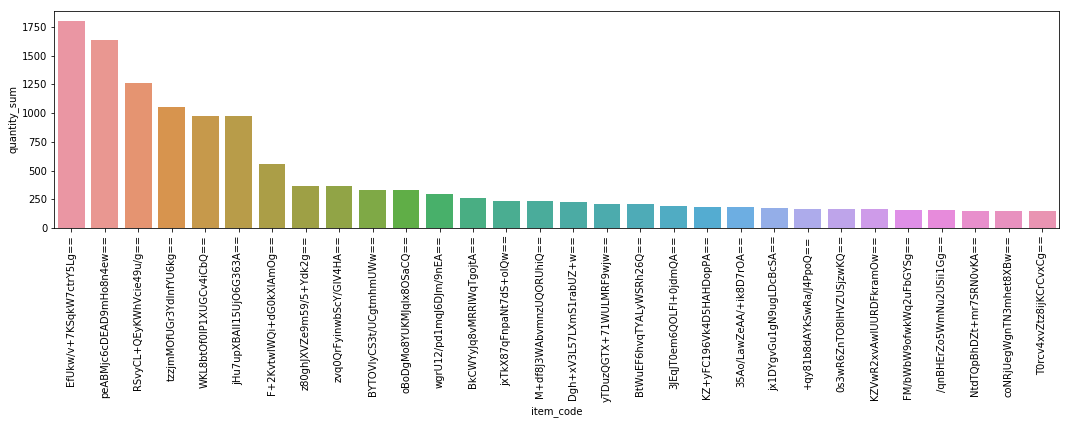

In [36]:
fig, ax = plt.subplots(1, 1, figsize=(18,4))

g = sns.barplot(x='item_code', y='members_count', data=members_counts.head(30), ax=ax)
locs, labels = plt.xticks()
_ = plt.setp(labels, rotation=90)

fig, ax = plt.subplots(1, 1, figsize=(18,4))
g = sns.barplot(x='item_code', y='quantity_sum', data=quantity_sums.head(30), ax=ax)
locs, labels = plt.xticks()
_ = plt.setp(labels, rotation=90)

## Random item recommendations (uniformly distributed)

In [37]:
import numpy as np

In [38]:
items_quantities = df.item_code
random_items = np.random.choice(items_quantities, 5)
random_items

array([u'yGp+49jvC1Ue1Y41SoNvKw==', u'iw0miWPdDPuAiqxIpUmCnw==',
       u'8JNeTNWSCqbHyZal7lOnDw==', u'b0ki9FVoFhqM30rSKZ9tIw==',
       u'2k+1xuk+dNPfhSdZn6YmQg=='], dtype=object)

In [39]:
dist_df\
.where(f.col('item_code').isin(*random_items))\
.groupBy('item_code').agg(f.count('*'), f.sum('quantity'))\
.show(truncate=False)

+------------------------+--------+-------------+
|item_code               |count(1)|sum(quantity)|
+------------------------+--------+-------------+
|8JNeTNWSCqbHyZal7lOnDw==|54      |55.0         |
|b0ki9FVoFhqM30rSKZ9tIw==|138     |140.0        |
|2k+1xuk+dNPfhSdZn6YmQg==|10      |10.0         |
|yGp+49jvC1Ue1Y41SoNvKw==|123     |128.0        |
|iw0miWPdDPuAiqxIpUmCnw==|23      |23.0         |
+------------------------+--------+-------------+



In [40]:
random_items_str = ','.join(list(random_items))
random_items_str

u'yGp+49jvC1Ue1Y41SoNvKw==,iw0miWPdDPuAiqxIpUmCnw==,8JNeTNWSCqbHyZal7lOnDw==,b0ki9FVoFhqM30rSKZ9tIw==,2k+1xuk+dNPfhSdZn6YmQg=='

## Benchmarking the results of all methods

In [41]:
full_recs = cf_member_recommendations\
.join(fp_recommendations, ['member_id'], 'fullouter')\
.drop(fp_recommendations['member_id'])\
.withColumn('top_5_by_members', f.lit(top_5_mc_str))\
.withColumn('top_5_by_quantity', f.lit(top_5_qs_str))\
.withColumn('random_5', f.lit(random_items_str))

full_recs.show()

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|           member_id|  cf_recommendations|  fp_recommendations|    top_5_by_members|   top_5_by_quantity|            random_5|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|0FA2aDI8HfSy46ebr...|[oBoDgMo8YUKMJqIx...|                null|EfUkw/v+7KSqkW7ct...|EfUkw/v+7KSqkW7ct...|yGp+49jvC1Ue1Y41S...|
|2qkpKiHwld05XQE6C...|[F+2KvtwlWQi+dG0k...|                null|EfUkw/v+7KSqkW7ct...|EfUkw/v+7KSqkW7ct...|yGp+49jvC1Ue1Y41S...|
|6PxLTVhv9oAXAYTkT...|[oBoDgMo8YUKMJqIx...|                null|EfUkw/v+7KSqkW7ct...|EfUkw/v+7KSqkW7ct...|yGp+49jvC1Ue1Y41S...|
|GBx8WjJH9L7xjCVgl...|[lqk7qJpbXGwibkm4...|                null|EfUkw/v+7KSqkW7ct...|EfUkw/v+7KSqkW7ct...|yGp+49jvC1Ue1Y41S...|
|IPKLX1E2sYio8xj0Q...|[7VGdrMibK+rT9FOw...|                null|EfUkw/v+7KSqkW7ct...|EfUkw/v+7KSqkW7ct..

In [42]:
full_recs.toPandas().head(20)

,member_id,cf_recommendations,fp_recommendations,top_5_by_members,top_5_by_quantity,random_5
0,0FA2aDI8HfSy46ebrgB7Gw==,"[oBoDgMo8YUKMJqIx8OSaCQ==, tzzjmMOfUGr3YdInfYU6kg==, peABMjc6cDEAD9mHo8n4ew==, jxTkX87qFnpaNt7dS+olQw==, WKL8btOf0IP1XUGCv4iCbQ==]",None,"EfUkw/v+7KSqkW7ctrY5Lg==,peABMjc6cDEAD9mHo8n4ew==,RSvyCL+QEyKWhVcie49u/g==,WKL8btOf0IP1XUGCv4iCbQ==,jHu7upXBAll15UjO6G363A==","EfUkw/v+7KSqkW7ctrY5Lg==,peABMjc6cDEAD9mHo8n4ew==,RSvyCL+QEyKWhVcie49u/g==,tzzjmMOfUGr3YdInfYU6kg==,WKL8btOf0IP1XUGCv4iCbQ==","yGp+49jvC1Ue1Y41SoNvKw==,iw0miWPdDPuAiqxIpUmCnw==,8JNeTNWSCqbHyZal7lOnDw==,b0ki9FVoFhqM30rSKZ9tIw==,2k+1xuk+dNPfhSdZn6YmQg=="
1,2qkpKiHwld05XQE6CVGK7Q==,"[F+2KvtwlWQi+dG0kXlAmOg==, Dgh+xV3L57LXmS1rabUZ+w==, FM/bWbW9ofwkWq2uFbGYSg==, BtWuEF6hvqTYALyWSRh26Q==, zvq0QrFyinwbScY/GlV4HA==]",None,"EfUkw/v+7KSqkW7ctrY5Lg==,peABMjc6cDEAD9mHo8n4ew==,RSvyCL+QEyKWhVcie49u/g==,WKL8btOf0IP1XUGCv4iCbQ==,jHu7upXBAll15UjO6G363A==","EfUkw/v+7KSqkW7ctrY5Lg==,peABMjc6cDEAD9mHo8n4ew==,RSvyCL+QEyKWhVcie49u/g==,tzzjmMOfUGr3YdInfYU6kg==,WKL8btOf0IP1XUGCv4iCbQ==","yGp+49jvC1Ue1Y41SoNvKw==,iw0miWPdDPuAiqxIpUmCnw==,8JNeTNWSCqbHyZal7lOnDw==,b0ki9FVoFhqM30rSKZ9tIw==,2k+1xuk+dNPfhSdZn6YmQg=="
2,6PxLTVhv9oAXAYTkTO+OYQ==,"[oBoDgMo8YUKMJqIx8OSaCQ==, M+df8J3WAbvmnzUQORUhiQ==, jHu7upXBAll15UjO6G363A==, PFncBI6IUCQ76AeaXHTQeQ==, fqy1MlcP9oWK/ScjdV/3kA==]",None,"EfUkw/v+7KSqkW7ctrY5Lg==,peABMjc6cDEAD9mHo8n4ew==,RSvyCL+QEyKWhVcie49u/g==,WKL8btOf0IP1XUGCv4iCbQ==,jHu7upXBAll15UjO6G363A==","EfUkw/v+7KSqkW7ctrY5Lg==,peABMjc6cDEAD9mHo8n4ew==,RSvyCL+QEyKWhVcie49u/g==,tzzjmMOfUGr3YdInfYU6kg==,WKL8btOf0IP1XUGCv4iCbQ==","yGp+49jvC1Ue1Y41SoNvKw==,iw0miWPdDPuAiqxIpUmCnw==,8JNeTNWSCqbHyZal7lOnDw==,b0ki9FVoFhqM30rSKZ9tIw==,2k+1xuk+dNPfhSdZn6YmQg=="
3,GBx8WjJH9L7xjCVglwoksA==,"[lqk7qJpbXGwibkm4iXP0bg==, RSvyCL+QEyKWhVcie49u/g==, jHu7upXBAll15UjO6G363A==, XUTubyw/cbcxJYdhA8j2xA==, KZ+yFC196Vk4D5HAHDopPA==]",None,"EfUkw/v+7KSqkW7ctrY5Lg==,peABMjc6cDEAD9mHo8n4ew==,RSvyCL+QEyKWhVcie49u/g==,WKL8btOf0IP1XUGCv4iCbQ==,jHu7upXBAll15UjO6G363A==","EfUkw/v+7KSqkW7ctrY5Lg==,peABMjc6cDEAD9mHo8n4ew==,RSvyCL+QEyKWhVcie49u/g==,tzzjmMOfUGr3YdInfYU6kg==,WKL8btOf0IP1XUGCv4iCbQ==","yGp+49jvC1Ue1Y41SoNvKw==,iw0miWPdDPuAiqxIpUmCnw==,8JNeTNWSCqbHyZal7lOnDw==,b0ki9FVoFhqM30rSKZ9tIw==,2k+1xuk+dNPfhSdZn6YmQg=="
4,IPKLX1E2sYio8xj0Q2j8sA==,"[7VGdrMibK+rT9FOwsFpKiw==, SJ0DluaCbrDB5hHYLKiyFQ==, b0ki9FVoFhqM30rSKZ9tIw==, z80ghJXVZe9m59/5+Ydk2g==, /qnBHErZo5WmNu2USii1Gg==]",None,"EfUkw/v+7KSqkW7ctrY5Lg==,peABMjc6cDEAD9mHo8n4ew==,RSvyCL+QEyKWhVcie49u/g==,WKL8btOf0IP1XUGCv4iCbQ==,jHu7upXBAll15UjO6G363A==","EfUkw/v+7KSqkW7ctrY5Lg==,peABMjc6cDEAD9mHo8n4ew==,RSvyCL+QEyKWhVcie49u/g==,tzzjmMOfUGr3YdInfYU6kg==,WKL8btOf0IP1XUGCv4iCbQ==","yGp+49jvC1Ue1Y41SoNvKw==,iw0miWPdDPuAiqxIpUmCnw==,8JNeTNWSCqbHyZal7lOnDw==,b0ki9FVoFhqM30rSKZ9tIw==,2k+1xuk+dNPfhSdZn6YmQg=="
5,K6zzgRlsokXVRAEEdye7cQ==,"[RSvyCL+QEyKWhVcie49u/g==, jHu7upXBAll15UjO6G363A==, EfUkw/v+7KSqkW7ctrY5Lg==, zvq0QrFyinwbScY/GlV4HA==, yTDuzQGTX+71WULMRF9wjw==]",None,"EfUkw/v+7KSqkW7ctrY5Lg==,peABMjc6cDEAD9mHo8n4ew==,RSvyCL+QEyKWhVcie49u/g==,WKL8btOf0IP1XUGCv4iCbQ==,jHu7upXBAll15UjO6G363A==","EfUkw/v+7KSqkW7ctrY5Lg==,peABMjc6cDEAD9mHo8n4ew==,RSvyCL+QEyKWhVcie49u/g==,tzzjmMOfUGr3YdInfYU6kg==,WKL8btOf0IP1XUGCv4iCbQ==","yGp+49jvC1Ue1Y41SoNvKw==,iw0miWPdDPuAiqxIpUmCnw==,8JNeTNWSCqbHyZal7lOnDw==,b0ki9FVoFhqM30rSKZ9tIw==,2k+1xuk+dNPfhSdZn6YmQg=="
6,WZDUwRtk7P3EM0+06vZRwA==,"[7VGdrMibK+rT9FOwsFpKiw==, tzzjmMOfUGr3YdInfYU6kg==, SJ0DluaCbrDB5hHYLKiyFQ==, z80ghJXVZe9m59/5+Ydk2g==, /qnBHErZo5WmNu2USii1Gg==]",None,"EfUkw/v+7KSqkW7ctrY5Lg==,peABMjc6cDEAD9mHo8n4ew==,RSvyCL+QEyKWhVcie49u/g==,WKL8btOf0IP1XUGCv4iCbQ==,jHu7upXBAll15UjO6G363A==","EfUkw/v+7KSqkW7ctrY5Lg==,peABMjc6cDEAD9mHo8n4ew==,RSvyCL+QEyKWhVcie49u/g==,tzzjmMOfUGr3YdInfYU6kg==,WKL8btOf0IP1XUGCv4iCbQ==","yGp+49jvC1Ue1Y41SoNvKw==,iw0miWPdDPuAiqxIpUmCnw==,8JNeTNWSCqbHyZal7lOnDw==,b0ki9FVoFhqM30rSKZ9tIw==,2k+1xuk+dNPfhSdZn6YmQg=="
7,XEs010yvWo0KDHmOh/2iIw==,"[KZVwR2xvAwlUURDFkramOw==, jHu7upXBAll15UjO6G363A==, +qy8